In [9]:
import pandas as pd
from transformers import LlamaTokenizerFast
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
df = pd.read_csv('../data/prospectuses_data.csv')

# Get RmsId without suffixes
df['RmsId'] = df['Prospectus ID'].str.split('_').str[0]
df['RmsId'] = df['RmsId'].astype(int)
df.head()

Prospectus ID               Original Filename      Section ID  \
0             5  Preliminary Offerings 2021.pdf  failed parsing   
1           5_1              Offerings 2020.pdf               1   
2           5_1              Offerings 2020.pdf               1   
3           5_1              Offerings 2020.pdf               1   
4           5_1              Offerings 2020.pdf               1   

    Section Title   Subsection ID  \
0  failed parsing  failed parsing   
1    RISK FACTORS             1.1   
2    RISK FACTORS             1.1   
3    RISK FACTORS             1.1   
4    RISK FACTORS             1.1   

                                    Subsection Title Subsubsection ID  \
0                                     failed parsing   failed parsing   
1  Risks related to the ADLER Group’s Business Ac...            1.1.1   
2  Risks related to the ADLER Group’s Business Ac...            1.1.1   
3  Risks related to the ADLER Group’s Business Ac...            1.1.2   
4  Risks related to the ADLER Group’s Business Ac...            1.1.3   

                                 Subsubsection Title  \
0                                     failed parsing   
1  Our business is significantly dependent on our...   
2  Our business is significantly dependent on our...   
3  Our ability to operate our business successful...   
4  We rely on our ability to identify potential r...   

                                  Subsubsection Text  \
0                                     failed parsing   
1  We rely significantly on rental income. In the...   
2  We rely significantly on rental income. In the...   
3  We face the risk that we may not be able to ge...   
4  As part of our strategy, we evaluate real esta...   

                                       Parsing Error From Folder  \
0  Exception occurred: local variable 'section_id...  raw_manual   
1                                                NaN  raw_manual   
2                                                NaN  raw_manual   
3                                                NaN  raw_manual   
4                                                NaN  raw_manual   

   Prospectus Year  RmsId  
0             2021      5  
1             2020      5  
2             2020      5  
3             2020      5  
4             2020      5

### Ehh

Token indices sequence length is longer than the specified maximum sequence length for this model (2230 > 2048). Running this sequence through the model will result in indexing errors


Maximum number of tokens in a prompt: 9793

Details of the prompt with maximum tokens:
Subsection Title: nan
Subsection Text: _We have taken on significant debt, which may adversely affect our business._ We have a substantial amount of indebtedness. As of March 31, 2021, after giving effect to the offering of the Notes offered hereby, the issuance and sale of the Existing Secured Notes, in each case the use of proceeds therefrom, and the creation of the New Revolving Credit Facility, our total consolidated indebtedness would have been approximately $5.4 billion, all of which we will need to refinance or repay. We would also have had $0.7 billion of secured borrowings drawn under our revolving credit facilities. There can be no assurances we will be able to refinance our indebtedness in the future (1) on commercially reasonable terms, (2) on terms, including with respect to interest rates, as favorable as our current debt or (3) at all. Our debt burden could have important consequences,

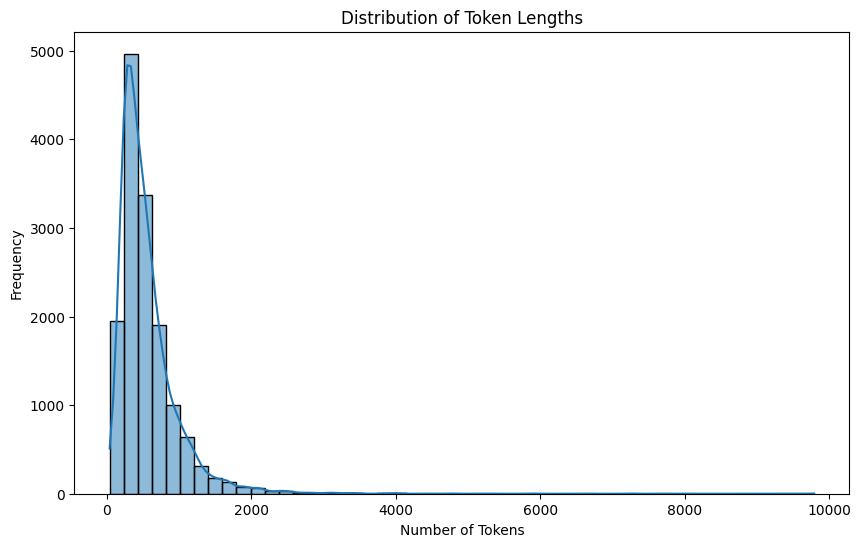

Maximum tokens (9793) plus buffer exceed current n_ctx (4096). Consider increasing n_ctx.


In [18]:
# Define your prompt templates
PROMPT_TEMPLATES = {
    "YES_NO_COT_PROMPT_TEMPLATE": "Please analyze the following subsection:\nTitle: {subsection_title}\nText: {subsection_text}\n\nDoes the text mention that the company is exposed to risks associated with cyclical products? Answer with Yes or No.",
    "YES_NO_BASE_PROMPT_TEMPLATE": "Analyze the subsection below.\nTitle: {subsection_title}\nText: {subsection_text}\n\nDoes the text mention exposure to cyclical product risks? Yes or No."
}

# Select the prompt template you are using
selected_prompt_template = PROMPT_TEMPLATES["YES_NO_COT_PROMPT_TEMPLATE"]

# Initialize the tokenizer
tokenizer = LlamaTokenizerFast.from_pretrained('hf-internal-testing/llama-tokenizer')

# Define the columns
SUBSECTION_TITLE_COLUMN = 'Subsubsection Title'  # Replace with your actual column name
SUBSECTION_TEXT_COLUMN = 'Subsubsection Text'    # Replace with your actual column name

# Ensure the columns exist
if SUBSECTION_TITLE_COLUMN not in df.columns or SUBSECTION_TEXT_COLUMN not in df.columns:
    raise ValueError(f"Required columns '{SUBSECTION_TITLE_COLUMN}' or '{SUBSECTION_TEXT_COLUMN}' not found in the data.")

# Function to create the prompt and calculate token length
def calculate_token_length(row):
    prompt = selected_prompt_template.format(
        subsection_title=row[SUBSECTION_TITLE_COLUMN],
        subsection_text=row[SUBSECTION_TEXT_COLUMN]
    )
    tokens = tokenizer.encode(prompt, add_special_tokens=False)
    return len(tokens)

# Apply the function to each row to get token lengths
df['token_length'] = df.apply(calculate_token_length, axis=1)

# Maximum token length
max_tokens = df['token_length'].max()
max_token_row = df.loc[df['token_length'].idxmax()]
print(f"Maximum number of tokens in a prompt: {max_tokens}")

print("\nDetails of the prompt with maximum tokens:")
print(f"Subsection Title: {max_token_row[SUBSECTION_TITLE_COLUMN]}")
print(f"Subsection Text: {max_token_row[SUBSECTION_TEXT_COLUMN]}")
print(f"Prompt: {selected_prompt_template.format(subsection_title=max_token_row[SUBSECTION_TITLE_COLUMN], subsection_text=max_token_row[SUBSECTION_TEXT_COLUMN])}")

# Additional statistics
print("\nToken Length Statistics:")
print(df['token_length'].describe())

# Visualize the distribution
plt.figure(figsize=(10,6))
sns.histplot(df['token_length'], bins=50, kde=True)
plt.title('Distribution of Token Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

# Decide on n_ctx
current_n_ctx = 4096  # As set in your script
buffer = 100  # Additional buffer

if max_tokens + buffer > current_n_ctx:
    print(f"Maximum tokens ({max_tokens}) plus buffer exceed current n_ctx ({current_n_ctx}). Consider increasing n_ctx.")
else:
    print(f"Maximum tokens ({max_tokens}) plus buffer are within the current n_ctx ({current_n_ctx}).")

In [20]:
# List of n_ctx values to evaluate
n_ctx_values = [8192, 4096, 2048]

# Check and print the number of rows exceeding each n_ctx value
for current_n_ctx in n_ctx_values:
    rows_exceeding_n_ctx = (df['token_length'] > current_n_ctx).sum()
    print(f"Number of rows exceeding n_ctx ({current_n_ctx}): {rows_exceeding_n_ctx}")

Number of rows exceeding n_ctx (8192): 3
Number of rows exceeding n_ctx (4096): 15
Number of rows exceeding n_ctx (2048): 181


### Merge with issuer data from DB

In [60]:
from capfourpy.databases import Database
db = Database(database="C4DW")

issuer_data_query = """
WITH RankedIssuerData AS (
  SELECT 
    RmsId, 
    AbbrevName, 
    CapFourIndustry, 
    CountryIsoOperating,
    ROW_NUMBER() OVER (PARTITION BY RmsId ORDER BY AbbrevName ASC) AS rn
  FROM [C4DW].[DailyOverview].[IssuerData]
  WHERE RmsId IS NOT NULL 
    AND RmsId > 0
	AND CapFourIndustry IS NOT NULL
	AND CountryIsoOperating IS NOT NULL
)
SELECT 
  RmsId, 
  AbbrevName, 
  CapFourIndustry, 
  CountryIsoOperating
FROM RankedIssuerData
WHERE rn = 1;
"""

data_database = db.read_sql(issuer_data_query)

# Merge data from df with data from data_database left on RmsId
df = df.merge(data_database, on='RmsId', how='left')
df


Prospectus ID               Original Filename      Section ID  \
0                 5  Preliminary Offerings 2021.pdf  failed parsing   
1               5_1              Offerings 2020.pdf               1   
2               5_1              Offerings 2020.pdf               1   
3               5_1              Offerings 2020.pdf               1   
4               5_1              Offerings 2020.pdf               1   
...             ...                             ...             ...   
14725          1994  Preliminary Offerings 2024.pdf               1   
14726          1994  Preliminary Offerings 2024.pdf               1   
14727          1994  Preliminary Offerings 2024.pdf               1   
14728          1994  Preliminary Offerings 2024.pdf               1   
14729          2004              Offerings 2021.pdf  failed parsing   

        Section Title   Subsection ID  \
0      failed parsing  failed parsing   
1        RISK FACTORS             1.1   
2        RISK FACTORS             1.1   
3        RISK FACTORS             1.1   
4        RISK FACTORS             1.1   
...               ...             ...   
14725    RISK FACTORS             1.6   
14726    RISK FACTORS             1.6   
14727    RISK FACTORS             1.6   
14728    RISK FACTORS             1.7   
14729  failed parsing  failed parsing   

                                        Subsection Title Subsubsection ID  \
0                                         failed parsing   failed parsing   
1      Risks related to the ADLER Group’s Business Ac...            1.1.1   
2      Risks related to the ADLER Group’s Business Ac...            1.1.1   
3      Risks related to the ADLER Group’s Business Ac...            1.1.2   
4      Risks related to the ADLER Group’s Business Ac...            1.1.3   
...                                                  ...              ...   
14725    Risks Related to Our Indebtedness and the Notes           1.6.35   
14726    Risks Related to Our Indebtedness and the Notes           1.6.36   
14727    Risks Related to Our Indebtedness and the Notes           1.6.37   
14728                                                NaN            1.7.1   
14729                                     failed parsing   failed parsing   

                                     Subsubsection Title  \
0                                         failed parsing   
1      Our business is significantly dependent on our...   
2      Our business is significantly dependent on our...   
3      Our ability to operate our business successful...   
4      We rely on our ability to identify potential r...   
...                                                  ...   
14725  Unless the Acquisition will be consummated on ...   
14726  If this offering closes prior to the consummat...   
14727  In a bankruptcy proceeding, the holders of not...   
14728                                                NaN   
14729                                     failed parsing   

                                      Subsubsection Text  \
0                                         failed parsing   
1      We rely significantly on rental income. In the...   
2      We rely significantly on rental income. In the...   
3      We face the risk that we may not be able to ge...   
4      As part of our strategy, we evaluate real esta...   
...                                                  ...   
14725  Unless the Acquisition will be consummated on ...   
14726  If this offering closes prior to the consummat...   
14727  If either of the Escrow Issuers commences a ba...   
14728  _Investing in our notes involves a high degree...   
14729                                     failed parsing   

                                           Parsing Error From Folder  \
0      Exception occurred: local variable 'section_id...  raw_manual   
1                                                    NaN  raw_manual   
2                                                    NaN  raw_manual   
3    

### Basic Statistics

In [61]:
# Print Unique RmsIds
print(f"Unique RmsIds: {df['RmsId'].nunique()}")

Unique RmsIds: 199


In [62]:
# Identify the largest suffix per RmsId
df['Suffix'] = df['Prospectus ID'].str.split('_').str[1].fillna('0').astype(int)
largest_suffix_df = df.loc[df.groupby('RmsId')['Suffix'].idxmax()]

# Filter rows with "failed parsing" in 'Section ID'
failed_parsing_df = largest_suffix_df[largest_suffix_df['Section ID'] == 'failed parsing']
print(f"Count of distinct RmsId with 'failed parsing' in the largest suffix or single ID: ")
print(failed_parsing_df['RmsId'].nunique())

# Filter rows where "Section ID" is NOT "failed parsing"
non_failed_parsing_df = largest_suffix_df[largest_suffix_df['Section ID'] != 'failed parsing']
print(f"Count of distinct RmsId without 'failed parsing' in the largest suffix or single ID: ")
print(non_failed_parsing_df['RmsId'].nunique())



Count of distinct RmsId with 'failed parsing' in the largest suffix or single ID: 
21
Count of distinct RmsId without 'failed parsing' in the largest suffix or single ID: 
178


**Countries**

In [73]:
# Count distinct RmsId within each CountryIsoOperating
distinct_rmsid_country = df.groupby('CountryIsoOperating')['RmsId'].nunique().reset_index()
distinct_rmsid_country.rename(columns={'RmsId': 'Distinct_RmsId_Count'}, inplace=True)

distinct_rmsid_country

CountryIsoOperating  Distinct_RmsId_Count
0                   AE                     1
1                   BE                     1
2                   BS                     1
3                   CA                     5
4                   CH                     3
5                   DE                    17
6                   DK                     4
7                   ES                     4
8                   FI                     2
9                   FR                    13
10                  GB                    33
11                  IE                     3
12                  IL                     1
13                  IT                    12
14                  JE                     2
15                  LU                     8
16                  NL                    12
17                  PA                     1
18                  PL                     1
19                  SE                     1
20                  US                    74

**Industries**

In [66]:
# Count distinct RmsId within each CapFourIndustry
distinct_rmsid_industry = df.groupby('CapFourIndustry')['RmsId'].nunique().reset_index()
distinct_rmsid_industry.rename(columns={'RmsId': 'Distinct_RmsId_Count'}, inplace=True)

print(distinct_rmsid_industry)

             CapFourIndustry  Distinct_RmsId_Count
0                 Automotive                     9
1             Basic Industry                    26
2              Capital Goods                    19
3             Consumer Goods                    14
4         Financial Services                     7
5                 Healthcare                    18
6                  Insurance                     6
7                    Leisure                    13
8                      Media                    10
9                Real Estate                     4
10                    Retail                    17
11                  Services                    24
12  Technology & Electronics                    11
13        Telecommunications                    16
14            Transportation                     2
15                   Utility                     3


**Years**

In [65]:
# Count distinct RmsId within each Prospectus Year
distinct_rmsid_year = df.groupby('Prospectus Year')['RmsId'].nunique().reset_index()
distinct_rmsid_year.rename(columns={'RmsId': 'Distinct_RmsId_Count'}, inplace=True)

print(distinct_rmsid_year)

    Prospectus Year  Distinct_RmsId_Count
0              2007                     1
1              2010                     1
2              2012                     4
3              2013                     3
4              2014                     7
5              2015                     7
6              2016                    11
7              2017                    13
8              2018                    17
9              2019                    15
10             2020                    42
11             2021                    77
12             2022                    15
13             2023                    30
14             2024                    39


### Document Statistics

In [71]:
# Add a column for the length of 'Subsubsection Title'
df['Subsubsection_Title_Length'] = df['Subsubsection Title'].astype(str).str.len()
df['Subsubsection_Text_Length'] = df['Subsubsection Text'].astype(str).str.len()

df[['Subsubsection Title', 'Subsubsection_Title_Length', 'Subsubsection Text', 'Subsubsection_Text_Length']].head()

Subsubsection Title  \
0                                     failed parsing   
1  Our business is significantly dependent on our...   
2  Our business is significantly dependent on our...   
3  Our ability to operate our business successful...   
4  We rely on our ability to identify potential r...   

   Subsubsection_Title_Length  \
0                          14   
1                         209   
2                         209   
3                         413   
4                         345   

                                  Subsubsection Text  \
0                                     failed parsing   
1  We rely significantly on rental income. In the...   
2  We rely significantly on rental income. In the...   
3  We face the risk that we may not be able to ge...   
4  As part of our strategy, we evaluate real esta...   

   Subsubsection_Text_Length  
0                         14  
1                        365  
2                       2591  
3                       4817  
4                       6745

In [72]:
# Group by 'Prospectus ID' and count the number of rows
prospectus_counts = df.groupby('Prospectus ID').size().reset_index(name='Row_Count')

# Calculate minimum, average, and maximum
min_count = prospectus_counts['Row_Count'].min()
avg_count = prospectus_counts['Row_Count'].mean()
max_count = prospectus_counts['Row_Count'].max()

print(f"Minimum number of rows per Prospectus ID: {min_count}")
print(f"Average number of rows per Prospectus ID: {avg_count:.2f}")
print(f"Maximum number of rows per Prospectus ID: {max_count}")

Minimum number of rows per Prospectus ID: 1
Average number of rows per Prospectus ID: 40.92
Maximum number of rows per Prospectus ID: 207
